<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/main/sample_emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [43]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense, Embedding, Flatten
from keras.models import Sequential
from keras.metrics import Precision, Recall
from keras.optimizers import Adam, RMSprop
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [36]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/emotion/data/go_preprocessed.csv'
metr = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
seed = 123456
num_words = 10000
max_len = 250

In [5]:
data = read_data(data_path,cols)
data.sample(5)

,text,target
18179,i love name but hate royals and wow this versi...,disgust
9465,traded me away the bastard kidding aside it th...,anger
50283,no the bubble is love the bubble is life with ...,joy
60913,we tried the place i go is just a rundown old ...,sadness
25851,name was good in my love from the star,joy


In [8]:
train, test = train_test_split(data, test_size=0.35, \
                             random_state=seed, stratify=data['target'])

In [9]:
val, test = train_test_split(test, test_size=0.5, \
                             random_state=seed, stratify=test['target'])

In [10]:
train.shape, val.shape, test.shape

((57870, 2), (15580, 2), (15581, 2))

In [11]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [17]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])
sequence_test = get_sequences(tokenizer, max_len, test['text'])

In [18]:
print(val['target'].unique(), \
      train['target'].unique(), \
      test['target'].unique())

['joy' 'anger' 'disgust' 'surprise' 'sadness' 'fear'] ['fear' 'joy' 'sadness' 'anger' 'surprise' 'disgust'] ['sadness' 'surprise' 'anger' 'joy' 'disgust' 'fear']


In [19]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])
test_target = OH_transform(test['target'])

In [50]:
def build_mlp():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(80, activation='sigmoid'))
    model.add(Dense(60, activation='sigmoid'))
    model.add(Dense(40, activation='sigmoid'))
    model.add(Dense(6, activation='softmax'))
    return model

In [28]:
def build_emb():
    model = Sequential()
    model.add(Input(shape=(max_len)))
    model.add(Embedding(num_words,32))
    model.add(Flatten())
    model.add(Dense(6, activation='softmax'))
    return model

In [51]:
mlp_model = build_mlp()
mlp_model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
mlp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 40)                10040     
_________________________________________________________________
dense_14 (Dense)             (None, 60)                2460      
_________________________________________________________________
dense_15 (Dense)             (None, 80)                4880      
_________________________________________________________________
dense_16 (Dense)             (None, 100)               8100      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_18 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_19 (Dense)             (None, 40)               

In [30]:
mlp_cb = get_callbacks('mlp_3H.h5')

In [52]:
history_mlp = mlp_model.fit(
    sequence_train,
    train_target,
    validation_data=(sequence_val, val_target),
    epochs = 100,
    batch_size=64,
    callbacks=mlp_cb
)

Epoch 1/100
905/905 [==============================] - 4s 3ms/step - loss: 1.8113 - accuracy: 0.2156 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5374 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00001: val_loss did not improve from 1.52669
Epoch 2/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5289 - accuracy: 0.4001 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5291 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00002: val_loss did not improve from 1.52669
Epoch 3/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5323 - accuracy: 0.3948 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_loss: 1.5290 - val_accuracy: 0.3956 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00

Epoch 00003: val_loss did not improve from 1.52669
Epoch 4/100
905/905 [==============================] - 3s 3ms/step - loss: 1.5333 - accuracy: 0.3

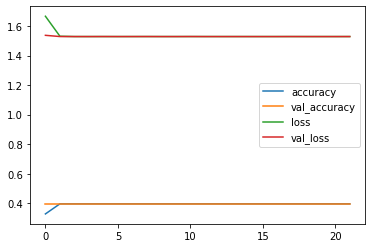

In [53]:
pd.DataFrame(history_mlp.history)[metr].plot()

In [31]:
emb_cb = get_callbacks('emb.h5')

In [29]:
emb_model = build_emb()
emb_model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall()
              ]
          )
emb_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 32)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 368,006
Trainable params: 368,006
Non-trainable params: 0
_________________________________________________________________
